In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.utils import resample

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# Download the 'punkt_tab' tokenizer data
nltk.download('punkt_tab')  # Add this line to download the missing data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
# Load dataset
data = pd.read_csv('Phishing_Email.csv')

# Drop the unnecessary column (if present)
data = data.drop(columns=["Unnamed: 0"], errors="ignore")

# Replace 'empty' with NaN
data['Email Text'].replace('empty', np.nan, inplace=True)

# Fill missing values with most frequent text
freq = data['Email Text'].mode()[0]
data['Email Text'] = data['Email Text'].fillna(freq)

# Remove duplicates
data = data.drop_duplicates(subset=['Email Text'], keep='first')
print(f"✅ Duplicate rows removed! New dataset shape: {data.shape}")

# Text Preprocessing
stopwords_set = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()


✅ Duplicate rows removed! New dataset shape: (17536, 2)


<ipython-input-2-be05bfb5c8e7>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Email Text'].replace('empty', np.nan, inplace=True)


In [3]:

def cleaning_text(text):
    text = str(text).lower()
    text = re.sub('<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_set]
    return ' '.join(words)

# Apply text cleaning
data = data.copy()
data.loc[:, 'clean_email'] = data['Email Text'].apply(cleaning_text)

# Convert labels to binary
data['Email Type'] = data['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})

data = data.drop(columns=["Email Text"], errors="ignore")

# Save cleaned dataset
data.to_csv("cleaned_phishing_email.csv", index=False)
print("Cleaned dataset saved successfully!")

# TF-IDF Vectorization
tfid = TfidfVectorizer()
tfid.fit(data['clean_email'].values)
matrix = tfid.transform(data['clean_email'].values)

# Split Data
x_train, x_test, y_train, y_test = train_test_split(matrix, data['Email Type'], test_size=0.33, random_state=42)


Cleaned dataset saved successfully!


<Axes: xlabel='Email Type', ylabel='count'>

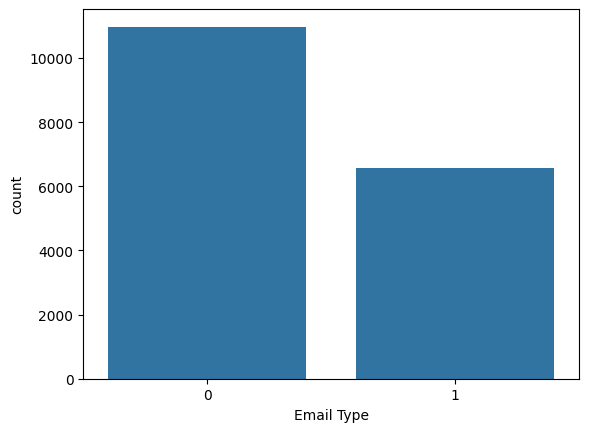

In [4]:
sns.countplot(data=data,x='Email Type')

In [5]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import joblib
import os
import numpy as np

# ✅ Check Apple MPS (Mac M3) or CUDA availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS for acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA for acceleration")
else:
    device = torch.device("cpu")
    print("Using CPU")



Using CUDA for acceleration


In [6]:
# ✅ Load dataset
df = pd.read_csv("cleaned_phishing_email.csv", usecols=["clean_email", "Email Type"])
df = df.dropna(subset=["clean_email"])
df["clean_email"] = df["clean_email"].astype(str)
df["Email Type"] = df["Email Type"].astype(int)

# ✅ Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["clean_email"].values, df["Email Type"].values, test_size=0.33, random_state=42, stratify=df["Email Type"]
)



<ipython-input-6-5e5113457d67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_email"] = df["clean_email"].astype(str)
<ipython-input-6-5e5113457d67>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Email Type"] = df["Email Type"].astype(int)


In [7]:
# ✅ TF-IDF Vectorization
tfid = TfidfVectorizer()
x_train_tfid = tfid.fit_transform(train_texts)
x_test_tfid = tfid.transform(test_texts)

# ✅ Individual Traditional Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

model_probs = []
print("\n🔍 Individual Model Evaluation:")
for name, model in models.items():
    model.fit(x_train_tfid, train_labels)
    probs = model.predict_proba(x_test_tfid)[:, 1]
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(test_labels, preds)
    prec = precision_score(test_labels, preds)
    rec = recall_score(test_labels, preds)
    f1 = f1_score(test_labels, preds)
    print(f"\n{name}:")
    print(f"Accuracy:  {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")
    model_probs.append(probs)




🔍 Individual Model Evaluation:

Logistic Regression:
Accuracy:  0.9715 | Precision: 0.9762 | Recall: 0.9468 | F1 Score: 0.9613

Naive Bayes:
Accuracy:  0.9198 | Precision: 0.9971 | Recall: 0.7878 | F1 Score: 0.8802

SVM:
Accuracy:  0.9831 | Precision: 0.9765 | Recall: 0.9783 | F1 Score: 0.9774

Random Forest:
Accuracy:  0.9696 | Precision: 0.9733 | Recall: 0.9445 | F1 Score: 0.9587

XGBoost:
Accuracy:  0.9666 | Precision: 0.9477 | Recall: 0.9639 | F1 Score: 0.9558


In [8]:
# ✅ BERT Tokenization and Dataloader
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256, return_tensors="pt")
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=256, return_tensors="pt")

train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], torch.tensor(train_labels))
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_bert.to(device)
optimizer = AdamW(model_bert.parameters(), lr=3e-5, eps=1e-8)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# ✅ Training loop
epochs = 3
model_bert.train()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        model_bert.zero_grad()
        outputs = model_bert(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    print(f"Average training loss: {avg_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")
    print(f"Average training loss: {avg_loss:.4f}\n")

Epoch 1/3
Average training loss: 0.1313 | Training Accuracy: 0.9499
Average training loss: 0.1313

Epoch 2/3
Average training loss: 0.0375 | Training Accuracy: 0.9881
Average training loss: 0.0375

Epoch 3/3
Average training loss: 0.0217 | Training Accuracy: 0.9928
Average training loss: 0.0217



In [10]:
# ✅ Get BERT Probabilities
model_bert.eval()
bert_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, _ = [b.to(device) for b in batch]
        outputs = model_bert(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        bert_probs.extend(probs.cpu().numpy())

model_probs.append(np.array(bert_probs))



In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

# ✅ Step 1: Compute F1 scores for traditional models
f1_weights = {}
model_probs_named = []   # Keep model probs in same order as f1_weights

print("\n🔍 Individual Model F1 Scores:")
for name, model in models.items():
    probs = model.predict_proba(x_test_tfid)[:, 1]
    preds = (probs >= 0.5).astype(int)
    f1 = f1_score(test_labels, preds)
    f1_weights[name] = f1
    model_probs_named.append(probs)  # Maintain same order
    print(f"{name}: {f1:.4f}")

# ✅ Step 2: Add BERT F1
bert_probs = np.array(bert_probs)  # ensure it's a NumPy array
bert_preds = (bert_probs >= 0.5).astype(int)
bert_f1 = f1_score(test_labels, bert_preds)
f1_weights["BERT"] = bert_f1
print(f"BERT: {bert_f1:.4f}")

# ✅ Step 3: Prepare probability array in order
model_names_ordered = list(f1_weights.keys())
all_probs = model_probs_named + [bert_probs]  # add BERT last
all_probs = np.array(all_probs)  # shape = (n_models, n_samples)

# ✅ Step 4: Prepare weight array in the same order
weights = np.array([f1_weights[name] for name in model_names_ordered]).reshape(-1, 1)  # shape = (n_models, 1)

# ✅ Step 5: Weighted average
weighted_probs = np.sum(all_probs * weights, axis=0) / np.sum(weights)
fusion_preds = (weighted_probs >= 0.5).astype(int)


🔍 Individual Model F1 Scores:
Logistic Regression: 0.9613
Naive Bayes: 0.8802
SVM: 0.9774
Random Forest: 0.9587
XGBoost: 0.9558
BERT: 0.9633



🔀 Fusion (TF-IDF + BERT with Weighted Soft Voting) Results
✅ Accuracy : 0.9876
✅ Precision: 0.9861
✅ Recall   : 0.9806
✅ F1 Score : 0.9833

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3623
           1       0.99      0.98      0.98      2163

    accuracy                           0.99      5786
   macro avg       0.99      0.99      0.99      5786
weighted avg       0.99      0.99      0.99      5786


Confusion Matrix:
 [[3593   30]
 [  42 2121]]


<Figure size 500x500 with 0 Axes>

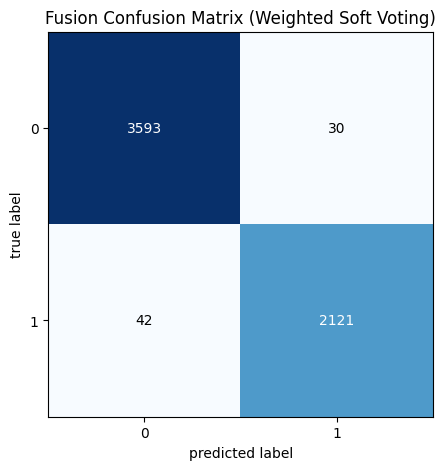

In [12]:
# ✅ Step 6: Evaluate Fusion Model
acc = accuracy_score(test_labels, fusion_preds)
prec = precision_score(test_labels, fusion_preds)
rec = recall_score(test_labels, fusion_preds)
f1 = f1_score(test_labels, fusion_preds)

print("\n🔀 Fusion (TF-IDF + BERT with Weighted Soft Voting) Results")
print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall   : {rec:.4f}")
print(f"✅ F1 Score : {f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(test_labels, fusion_preds))

# ✅ Confusion Matrix
cm = confusion_matrix(test_labels, fusion_preds)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(5, 5))
plot_confusion_matrix(cm, figsize=(5, 5), cmap="Blues")
plt.title("Fusion Confusion Matrix (Weighted Soft Voting)")
plt.show()

In [13]:
import joblib
import os
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# ✅ Custom Fusion Wrapper to save ensemble logic
class FusionModel:
    def __init__(self, models, tfid, bert_model, tokenizer, f1_weights, device):
        self.models = models
        self.tfid = tfid
        self.bert_model = bert_model
        self.tokenizer = tokenizer
        self.f1_weights = f1_weights
        self.device = device

    def predict_proba(self, texts):
        model_probs = []

        # Traditional models
        tfidf_vec = self.tfid.transform(texts)
        for name in self.models:
            probs = self.models[name].predict_proba(tfidf_vec)[:, 1]
            model_probs.append(probs)

        # BERT model
        self.bert_model.eval()
        bert_probs = []
        with torch.no_grad():
            for i in range(0, len(texts), 16):
                batch = texts[i:i+16]
                inputs = self.tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(self.device)
                logits = self.bert_model(**inputs).logits
                probs = torch.softmax(logits, dim=1)[:, 1]
                bert_probs.extend(probs.cpu().numpy())
        model_probs.append(np.array(bert_probs))

        # Soft voting with F1 weights
        weights = np.array(list(self.f1_weights.values())).reshape(-1, 1)
        all_probs = np.array(model_probs)
        return np.sum(all_probs * weights, axis=0) / np.sum(weights)

    def predict(self, texts):
        probs = self.predict_proba(texts)
        return (probs >= 0.5).astype(int)

# ✅ Create folders
os.makedirs("fusion_email_model", exist_ok=True)

# ✅ Save individual components
for name, model in models.items():
    joblib.dump(model, f"fusion_email_model/{name.replace(' ', '_').lower()}_model.pkl")
print("✅ Saved all traditional models")

joblib.dump(tfid, "fusion_email_model/tfid_vectorizer.pkl")
print("✅ Saved TF-IDF vectorizer")

try:
    model_bert.save_pretrained("fusion_email_model/bert/")
    tokenizer.save_pretrained("fusion_email_model/bert/")
    print("✅ Saved BERT model and tokenizer")
except Exception as e:
    print("❌ BERT save failed:", e)
    torch.save(model_bert.state_dict(), "fusion_email_model/bert_model_weights.pt")

# ✅ Save FusionModel wrapper as .pkl
fusion_model = FusionModel(models, tfid, model_bert, tokenizer, f1_weights, device)
joblib.dump(fusion_model, "fusion_email_model/fusion_model_email.pkl")
print("✅ Saved Fusion Model: fusion_model_email.pkl")

✅ Saved all traditional models
✅ Saved TF-IDF vectorizer
✅ Saved BERT model and tokenizer
✅ Saved Fusion Model: fusion_model_email.pkl


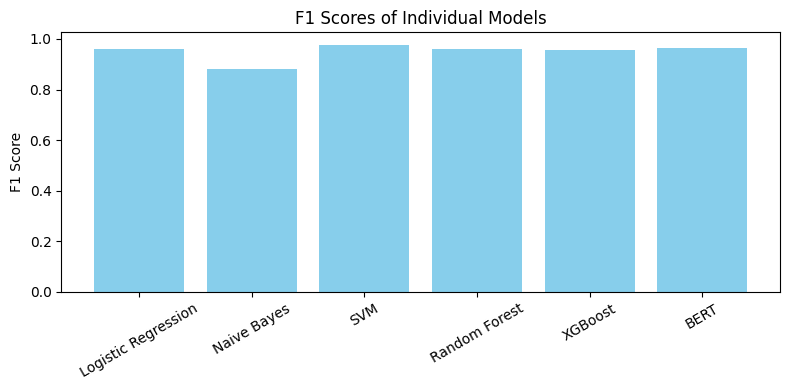

In [14]:
import matplotlib.pyplot as plt

# Bar Plot of F1 Scores
f1_scores = list(f1_weights.values())
model_names = list(f1_weights.keys())

plt.figure(figsize=(8, 4))
plt.bar(model_names, f1_scores, color='skyblue')
plt.ylabel("F1 Score")
plt.title("F1 Scores of Individual Models")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

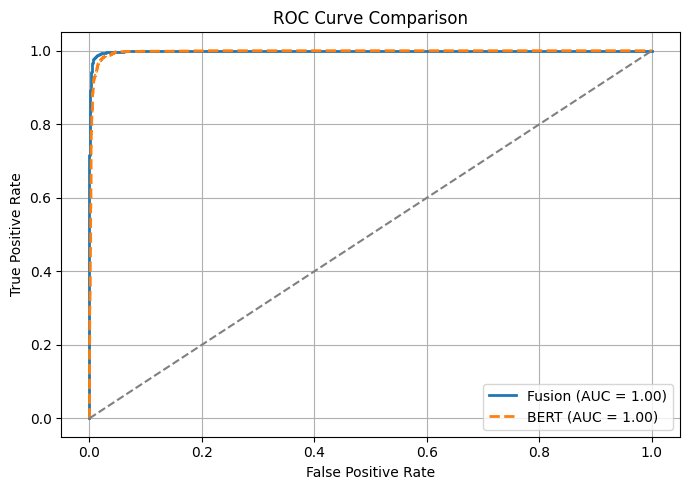

In [15]:
from sklearn.metrics import roc_curve, auc

fpr_fusion, tpr_fusion, _ = roc_curve(test_labels, weighted_probs)
fpr_bert, tpr_bert, _ = roc_curve(test_labels, bert_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr_fusion, tpr_fusion, label=f"Fusion (AUC = {auc(fpr_fusion, tpr_fusion):.2f})", linewidth=2)
plt.plot(fpr_bert, tpr_bert, label=f"BERT (AUC = {auc(fpr_bert, tpr_bert):.2f})", linewidth=2, linestyle="--")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<ipython-input-16-958fadb016e9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Email Type", data=df, palette="Set2")


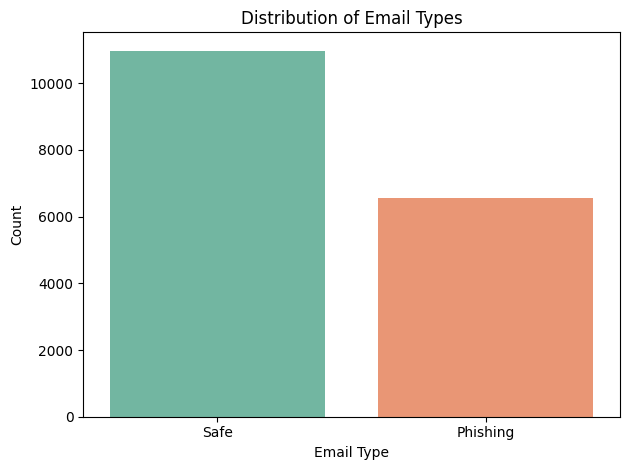

In [16]:
sns.countplot(x="Email Type", data=df, palette="Set2")
plt.title("Distribution of Email Types")
plt.xticks([0, 1], ["Safe", "Phishing"])
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


<ipython-input-17-a34b1b8bc137>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=f1_scores, palette="coolwarm")


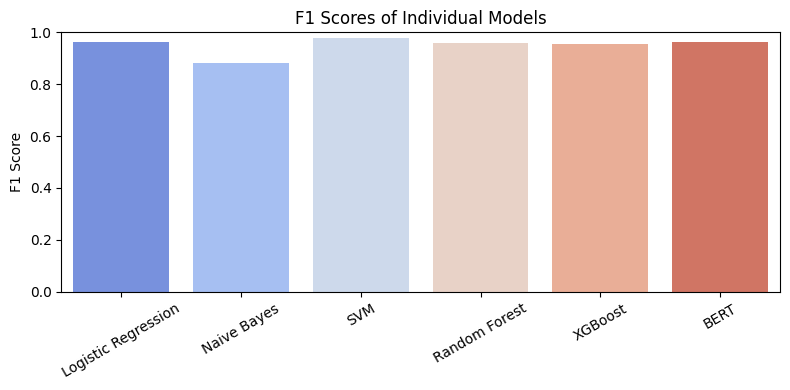

In [17]:
f1_scores = list(f1_weights.values())
model_names = list(f1_weights.keys())

plt.figure(figsize=(8, 4))
sns.barplot(x=model_names, y=f1_scores, palette="coolwarm")
plt.ylabel("F1 Score")
plt.title("F1 Scores of Individual Models")
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()